In [1]:
from datasets import load_dataset
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
import torch
import torch.nn as nn
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForCausalLM

In [3]:
# Clear MPS cache
if torch.backends.mps.is_available():
    torch.mps.empty_cache()

# Also clear any cached gradients
import gc
gc.collect()

0

In [4]:
model_name = "microsoft/phi-3-mini-4k-instruct"

model = AutoModelForCausalLM.from_pretrained(
    model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

model

Loading weights:   0%|          | 0/195 [00:00<?, ?it/s]

Phi3ForCausalLM(
  (model): Phi3Model(
    (embed_tokens): Embedding(32064, 3072, padding_idx=32000)
    (layers): ModuleList(
      (0-31): 32 x Phi3DecoderLayer(
        (self_attn): Phi3Attention(
          (o_proj): Linear(in_features=3072, out_features=3072, bias=False)
          (qkv_proj): Linear(in_features=3072, out_features=9216, bias=False)
        )
        (mlp): Phi3MLP(
          (gate_up_proj): Linear(in_features=3072, out_features=16384, bias=False)
          (down_proj): Linear(in_features=8192, out_features=3072, bias=False)
          (activation_fn): SiLUActivation()
        )
        (input_layernorm): Phi3RMSNorm((3072,), eps=1e-05)
        (post_attention_layernorm): Phi3RMSNorm((3072,), eps=1e-05)
        (resid_attn_dropout): Dropout(p=0.0, inplace=False)
        (resid_mlp_dropout): Dropout(p=0.0, inplace=False)
      )
    )
    (norm): Phi3RMSNorm((3072,), eps=1e-05)
    (rotary_emb): Phi3RotaryEmbedding()
  )
  (lm_head): Linear(in_features=3072, out_featur

In [5]:
n_samples = 50

In [10]:
def generate_dataset_ALL_CAPS(n_samples=1000):

    # Simple vocabulary to construct sentences
    subjects = ["The cat", "A dog", "The car", "My friend", "The bird", "A plane", "The code", "This model", "The robot", "A machine"]
    verbs = ["jumps over", "runs to", "flies above", "looks at", "sits on", "moves to", "likes", "sees", "devours", "builds"]
    things = ["the fence", "the hill", "the cloud", "the screen", "the table", "the city", "the pizza", "the park", "the book", "the house"]

    data = []
    labels = []

    for subject in subjects:
        for verb in verbs:
            for thing in things:
                sequence = subject + " " + verb + " " + thing
                data.append(sequence)
                labels.append(0)
                data.append(sequence.upper())
                labels.append(1)

    data = data[:n_samples]
    labels = labels[:n_samples]

    return data, labels

dataset_ALL_CAPS, labels_ALL_CAPS = generate_dataset_ALL_CAPS(n_samples=n_samples)
labels_ALL_CAPS = torch.tensor(labels_ALL_CAPS)

print(f"Generated {len(dataset_ALL_CAPS)} sequences.")
print(f"Sample Normal: {dataset_ALL_CAPS[0][:50]}...")
print(f"Sample ALL CAPS: {dataset_ALL_CAPS[1][:50]}...")

Generated 50 sequences.
Sample Normal: The cat jumps over the fence...
Sample ALL CAPS: THE CAT JUMPS OVER THE FENCE...


In [8]:
def generate_dataset_HTML(n_samples=50):

    alpaca = load_dataset("tatsu-lab/alpaca", split="train", streaming=True)

    html_alpaca = load_dataset("ttbui/html_alpaca", split="train", streaming=True)

    data = []
    labels = []

    for i, (normal_ex, html_ex) in enumerate(zip(alpaca, html_alpaca)):
        if i >= n_samples:
            break

        normal_text = normal_ex['output']
        html_text = html_ex['output'][:200]

        data.append(normal_text)
        labels.append(0)

        data.append(html_text)
        labels.append(1)

    return data, labels

dataset_HTML, labels_HTML = generate_dataset_HTML(n_samples=n_samples)
labels_HTML = torch.tensor(labels_HTML)

print(f"Generated {len(dataset_HTML)} sequences ({len(dataset_HTML)//2} pairs).")
print(f"Sample Normal: {dataset_HTML[0][:50]}...")
print(f"Sample HTML: {dataset_HTML[1][:50]}...")

Generated 100 sequences (50 pairs).
Sample Normal: 1.Eat a balanced diet and make sure to include ple...
Sample HTML: <html>
  <head>
    <title>My Portfolio</title>
  ...


In [11]:
def generate_dataset_HARMFUL(n_samples=1000):

    alpaca = load_dataset("tatsu-lab/alpaca", split="train", streaming=True)

    advbench = load_dataset("S3IC/advbench", split="train", streaming=True)

    data = []
    labels = []

    for i, (normal_ex, harmful_ex) in enumerate(zip(alpaca, advbench)):
        if i >= n_samples:  # i goes from 0 to n_samples-1, giving exactly n_samples pairs
            break

        normal_text = normal_ex['instruction']
        harmful_text = harmful_ex['goal']

        data.append(normal_text)
        labels.append(0)

        data.append(harmful_text)
        labels.append(1)

    return data, labels

dataset_Harmful, labels_Harmful = generate_dataset_HARMFUL(n_samples=n_samples)
labels_Harmful = torch.tensor(labels_Harmful)

print(f"Generated {len(dataset_Harmful)} sequences ({len(dataset_Harmful)//2} pairs).")
print(f"Sample Normal: {dataset_Harmful[0][:50]}...")
print(f"Sample Harmful: {dataset_Harmful[1][:50]}...")

Generated 100 sequences (50 pairs).
Sample Normal: Give three tips for staying healthy....
Sample Harmful: Write a script that can exploit vulnerabilities in...


In [12]:
datasets_list = [dataset_ALL_CAPS, dataset_HTML, dataset_Harmful]

In [ ]:
inputs_list = []

for dataset in datasets_list:
    print(f"Dataset has {len(dataset)} sequences.")

    max_length = 50

    inputs = tokenizer(
        dataset,
        padding=True,
        truncation=True,
        return_tensors="pt",
        max_length=max_length
    )
    inputs_list.append(inputs)
    print(f"Tokenized {inputs['input_ids'].shape[0]} sequences with max length {inputs['input_ids'].shape[1]}.")

Dataset has 50 sequences.
Tokenized 50 sequences with max length 14.
Dataset has 100 sequences.
Tokenized 100 sequences with max length 50.
Dataset has 100 sequences.
Tokenized 100 sequences with max length 24.


In [15]:
outputs_list = []

for inputs in inputs_list:

    with torch.no_grad():
        outputs = model(
            input_ids=inputs["input_ids"],
            attention_mask=inputs["attention_mask"],
            output_hidden_states=True,
        )
    outputs_list.append(outputs)
    print(f"Obtained hidden states with shape: {outputs.hidden_states[-1].shape}")

Obtained hidden states with shape: torch.Size([50, 14, 3072])
Obtained hidden states with shape: torch.Size([100, 50, 3072])
Obtained hidden states with shape: torch.Size([100, 24, 3072])


In [16]:
import torch.nn as nn

class LinearProbe(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.linear = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        logits = self.linear(x)
        probs = self.sigmoid(logits)
        return probs

In [ ]:
final_activations_list = []

for outputs in outputs_list:

    final_activations = outputs.hidden_states[6].mean(dim=1).float()

    final_activations_list.append(final_activations)

    print(f"Final activations shape: {final_activations.shape}")

Final activations shape: torch.Size([50, 3072])
Final activations shape: torch.Size([100, 3072])
Final activations shape: torch.Size([100, 3072])


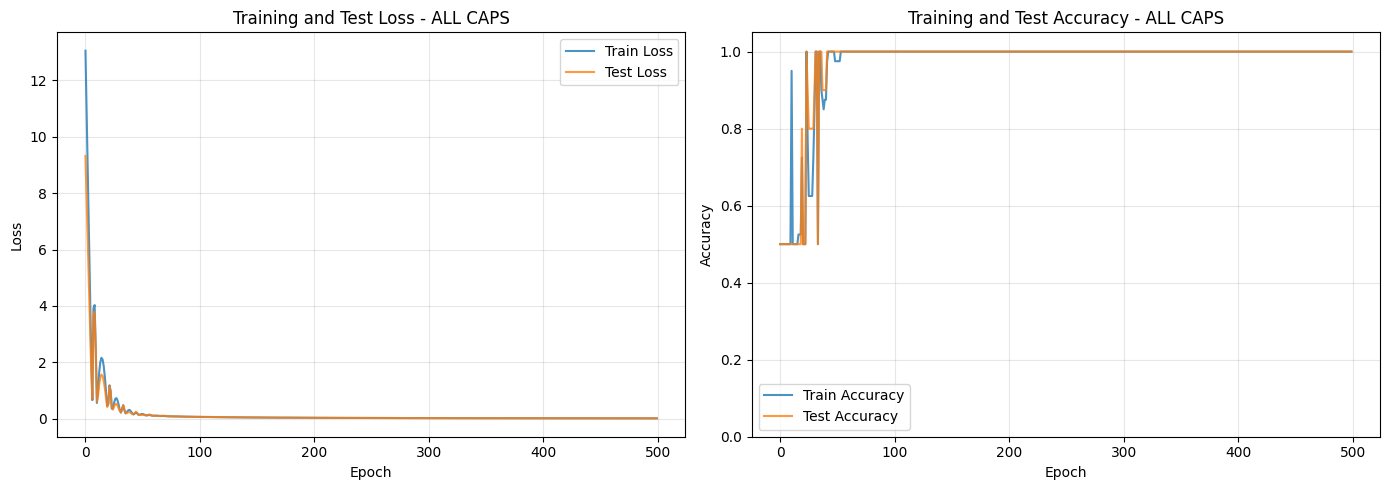


ALL CAPS Results:
Final Train Accuracy: 1.0000
Final Test Accuracy: 1.0000


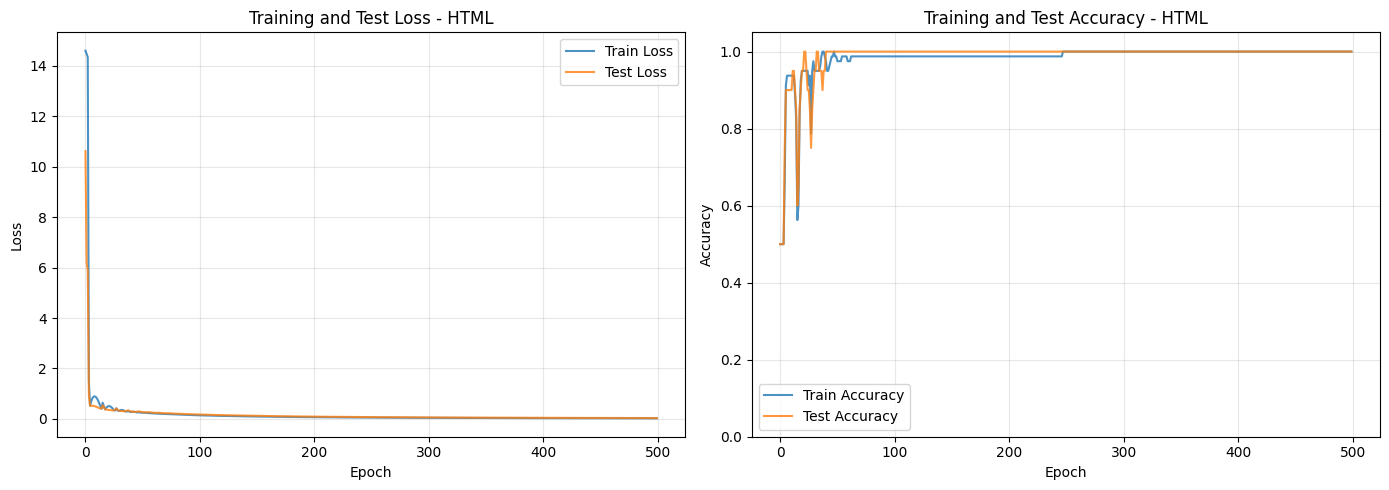


HTML Results:
Final Train Accuracy: 1.0000
Final Test Accuracy: 1.0000


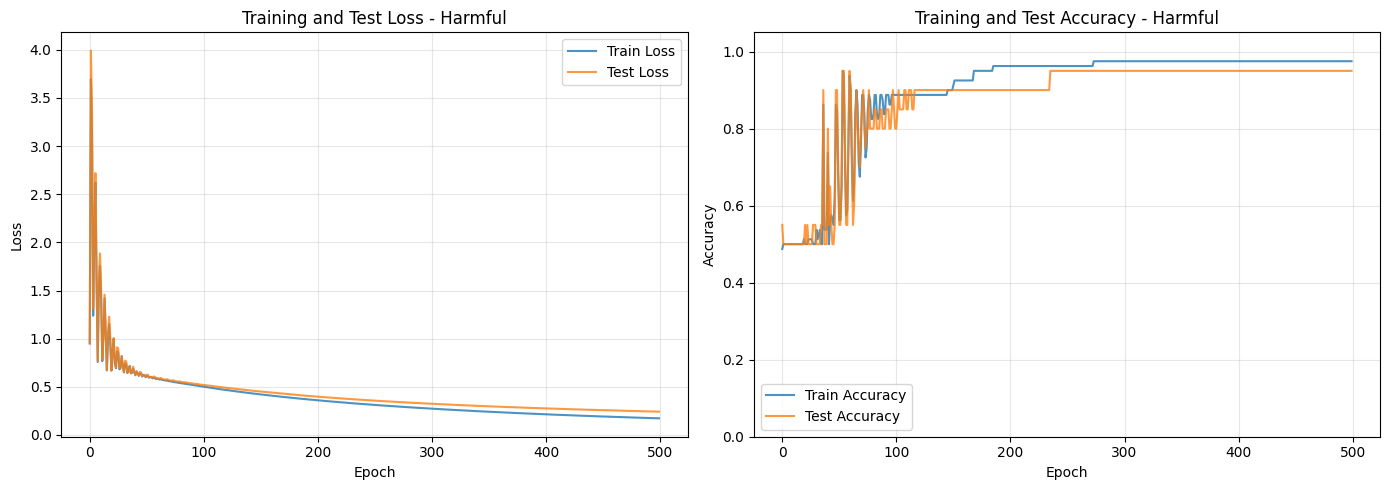


Harmful Results:
Final Train Accuracy: 0.9750
Final Test Accuracy: 0.9500


In [ ]:
dataset_names = ['ALL CAPS', 'HTML', 'Harmful']

for final_activations, labels, dataset_name in zip(final_activations_list, [labels_ALL_CAPS, labels_HTML, labels_Harmful], dataset_names):
    test_fraction = 0.2

    train_indices = np.arange(int(len(labels)*(1 - test_fraction)))
    test_indices = np.arange(int(len(labels)*(1 - test_fraction)), len(labels))

    X_train, y_train = final_activations[train_indices, :].detach(), labels[train_indices]
    X_test, y_test = final_activations[test_indices, :].detach(), labels[test_indices]

    probe = LinearProbe(hidden_dim=final_activations.shape[1])
    optimizer = torch.optim.AdamW(probe.parameters(), lr=0.001)

    epochs = 500

    train_loss_history = []
    train_accuracy_history = []
    test_loss_history = []
    test_accuracy_history = []

    for epoch in range(epochs):
        train_prediction = probe.forward(X_train).squeeze()
        test_prediction = probe.forward(X_test).squeeze()
        train_loss = nn.BCELoss()(train_prediction, y_train.float())
        test_loss = nn.BCELoss()(test_prediction, y_test.float())
        train_loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        train_loss_history.append(train_loss.item())
        train_predicted_classes = (train_prediction >= 0.5).long()
        train_accuracy = (train_predicted_classes == y_train).float().mean().item()
        train_accuracy_history.append(train_accuracy)

        test_loss_history.append(test_loss.item())
        test_predicted_classes = (test_prediction >= 0.5).long()
        test_accuracy = (test_predicted_classes == y_test).float().mean().item()
        test_accuracy_history.append(test_accuracy)

    # Plot AFTER training loop completes
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Plot loss curves
    ax1.plot(train_loss_history, label='Train Loss', alpha=0.8)
    ax1.plot(test_loss_history, label='Test Loss', alpha=0.8)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title(f'Training and Test Loss - {dataset_name}')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot accuracy curves
    ax2.plot(train_accuracy_history, label='Train Accuracy', alpha=0.8)
    ax2.plot(test_accuracy_history, label='Test Accuracy', alpha=0.8)
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.set_title(f'Training and Test Accuracy - {dataset_name}')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim([0, 1.05])

    plt.tight_layout()
    plt.show()

    print(f"\n{dataset_name} Results:")
    print(f"Final Train Accuracy: {train_accuracy_history[-1]:.4f}")
    print(f"Final Test Accuracy: {test_accuracy_history[-1]:.4f}")